In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

from sklearn.metrics import accuracy_score

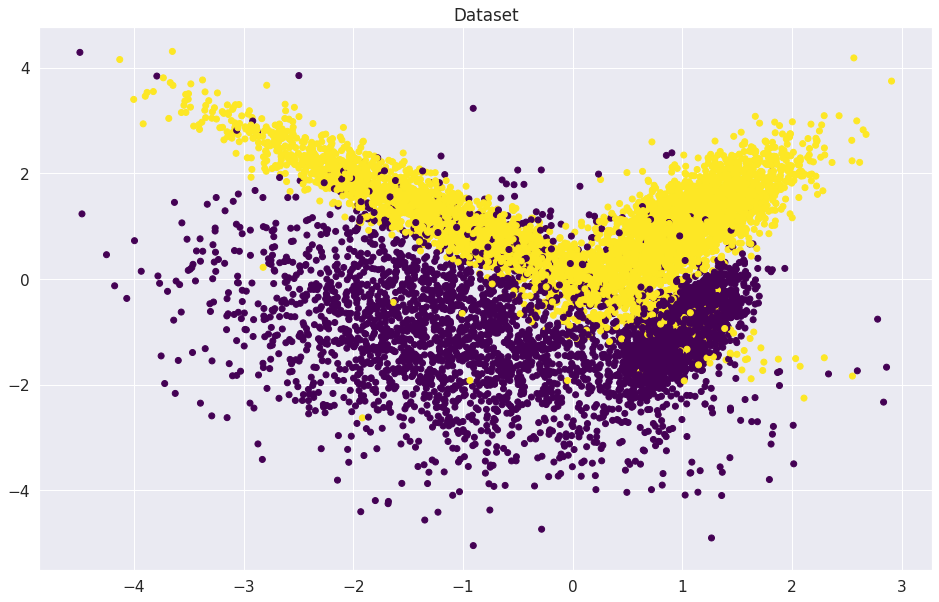

In [ ]:
X, Y = make_classification(n_samples=10000, n_features=2, n_redundant=0, random_state=42)
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="viridis")
plt.show()

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, random_state=42)

In [ ]:
X_train_t = torch.FloatTensor(X_train)
Y_train_t = torch.LongTensor(Y_train)
X_val_t = torch.FloatTensor(X_val)
Y_val_t = torch.LongTensor(Y_val)

In [ ]:
train_dataset = TensorDataset(X_train_t, Y_train_t)
val_dataset = TensorDataset(X_val_t, Y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        y = x @ self.weights
        if self.bias:
            y += self.bias_term
        return y.squeeze() # удалим лишнюю размерность

In [ ]:
xsize=X.shape
print(xsize)

(10000, 2)


In [ ]:
linear_regression = LinearRegression(xsize[1], 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [ ]:
for x in linear_regression.parameters():
  print(x)

Parameter containing:
tensor([[ 0.5085],
        [-0.2946]], requires_grad=True)
Parameter containing:
tensor([0.7426], requires_grad=True)


In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        
        optimizer.zero_grad()

        outp = linear_regression(X_batch)
        loss = loss_function(outp, y_batch.float())

        loss.backward()
        optimizer.step()

        
        losses.append(loss.detach().flatten()[0])
        
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)

        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")

        current_weights = linear_regression.weights.detach().clone()

        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}. Convergence. Stopping iterations.")
            stop_it = True
            break

        prev_weights = current_weights

    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.8984375
Iteration: 200
Batch accuracy: 0.921875

Iteration: 265. Convergence. Stopping iterations.


In [ ]:
def plot_losses(losses):
  plt.figure(figsize=(12, 8))
  plt.plot(range(len(losses)), losses)
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

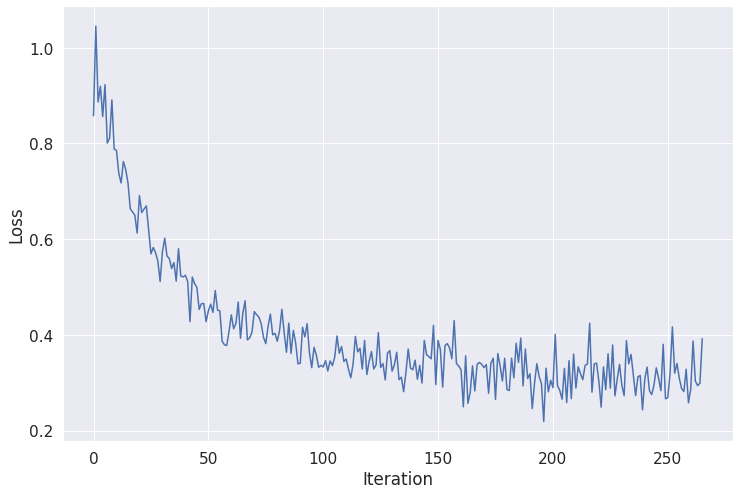

In [ ]:
plot_losses(losses)

In [ ]:
import numpy as np

def plot_map(model, X, Y):
  sns.set(style="white")

  xx, yy = np.mgrid[-5:5:.01, -6:6:.01]
  grid = np.c_[xx.ravel(), yy.ravel()]
  batch = torch.from_numpy(grid).type(torch.float32)
  with torch.no_grad():
      probs = torch.sigmoid(model(batch).reshape(xx.shape))
      probs = probs.numpy().reshape(xx.shape)

  f, ax = plt.subplots(figsize=(16, 10))
  ax.set_title("Decision boundary", fontsize=14)
  contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                        vmin=0, vmax=1)
  ax_c = f.colorbar(contour)
  ax_c.set_label("$P(y = 1)$")
  ax_c.set_ticks([0, .25, .5, .75, 1])

  ax.scatter(X[100:,0], X[100:, 1], c=Y[100:], s=50,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)

  ax.set(xlabel="$X_1$", ylabel="$X_2$")
  plt.show()

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        lgts = model(x_batch)
        probs = torch.sigmoid(lgts)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
Y_pred = predict(val_dataloader, linear_regression)
accuracy_score(Y_val, Y_pred)

0.8864

In [ ]:
class CustomRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))

        self.weights2 = nn.Parameter(torch.randn(in_features, out_features))

        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        y = x**2 @ self.weights2 + x @ self.weights
        if self.bias:
            y += self.bias_term
        return y.squeeze() # удалим лишнюю размерность

In [ ]:
def train(model, optimizer, loss_function, tol = 1e-3, max_epochs = 100):
  
  losses = []
  prev_weights = torch.zeros_like(model.weights)
  stop_it = False

  for epoch in range(max_epochs):
      for it, (X_batch, y_batch) in enumerate(train_dataloader):
          
          optimizer.zero_grad()

          outp = model(X_batch)
          loss = loss_function(outp, y_batch.float())

          loss.backward()
          optimizer.step()

          
          losses.append(loss.detach().flatten()[0])
          
          probabilities = torch.sigmoid(outp)
          preds = (probabilities > 0.5).type(torch.long)

          batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
          
          if (it + epoch * len(train_dataloader)) % 100 == 0:
              print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")

          current_weights = model.weights.detach().clone()

          if (prev_weights - current_weights).abs().max() < tol:
              print(f"\nIteration: {it + epoch * len(train_dataloader)}. Convergence. Stopping iterations.")
              stop_it = True
              break

          prev_weights = current_weights

      if stop_it:
          break

  return losses

In [ ]:
custom_model = CustomRegression(xsize[1], 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(custom_model.parameters(), lr=0.05)

In [ ]:
losses_custom = train(custom_model, optimizer, loss_function) 

Iteration: 0
Batch accuracy: 0.3828125
Iteration: 100
Batch accuracy: 0.65625
Iteration: 200
Batch accuracy: 0.875

Iteration: 240. Convergence. Stopping iterations.


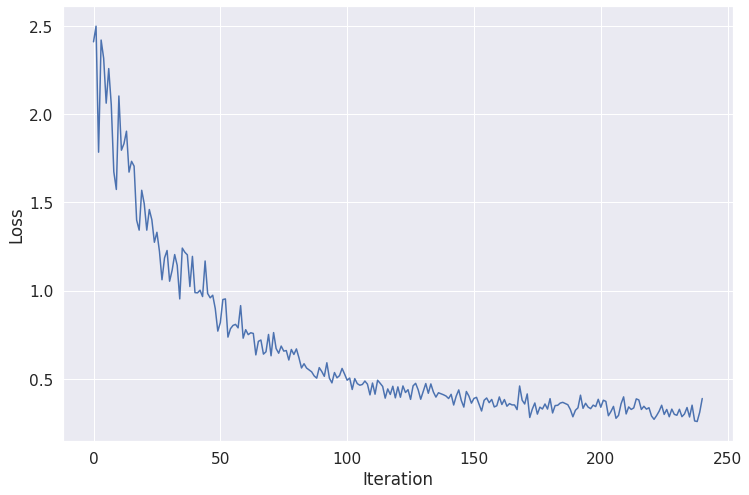

In [ ]:
plot_losses(losses_custom)

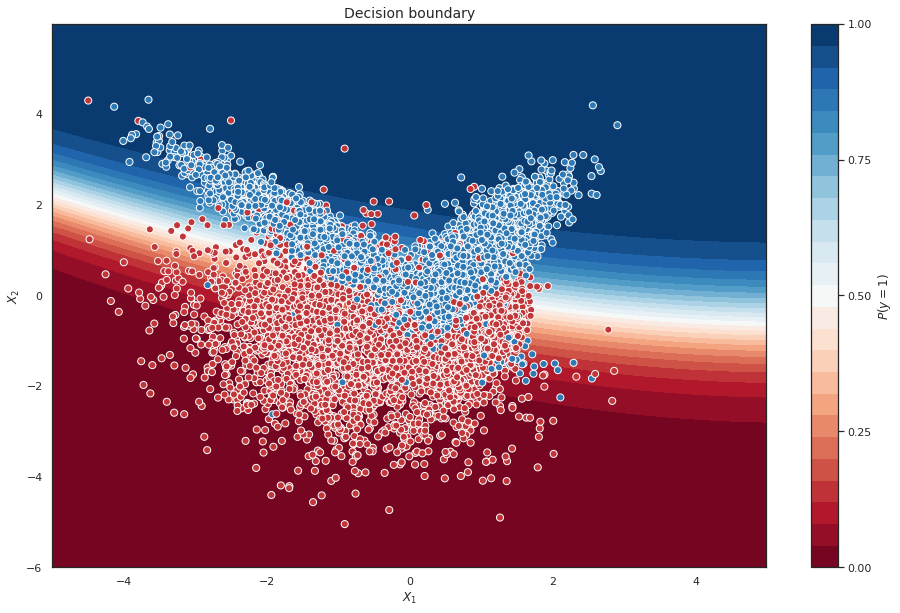

In [ ]:
plot_map(custom_model, X, Y)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        
        self.nn = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, out_features)
        )

    def forward(self, x):
        y = self.nn(x)

        return y.squeeze()

In [ ]:
nn_model = SimpleNN(xsize[1], 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.05)

In [ ]:
def train_nn2(model, optimizer, loss_function, tol = 1e-3, max_epochs = 100):
  
  losses = []
  # prev_weights = torch.zeros_like(model.weights)
  stop_it = False

  for epoch in range(max_epochs):
      for it, (X_batch, y_batch) in enumerate(train_dataloader):
          
          optimizer.zero_grad()

          outp = model(X_batch)
          loss = loss_function(outp, y_batch.float())

          loss.backward()
          optimizer.step()

          
          losses.append(loss.detach().flatten()[0])
          
          probabilities = torch.sigmoid(outp)
          preds = (probabilities > 0.5).type(torch.long)

          batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
          
          if (it + epoch * len(train_dataloader)) % 100 == 0:
              print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")

          #current_weights = model.weights.detach().clone()

          # if (prev_weights - current_weights).abs().max() < tol:
          #    print(f"\nIteration: {it + epoch * len(train_dataloader)}. Convergence. Stopping iterations.")
          #    stop_it = True
          #    break

          #prev_weights = current_weights

      if stop_it:
          break

  return losses

In [ ]:
losses_nn = train_nn2(nn_model, optimizer, loss_function) 

Iteration: 0
Batch accuracy: 0.84375
Iteration: 100
Batch accuracy: 0.9296875
Iteration: 200
Batch accuracy: 0.953125
Iteration: 300
Batch accuracy: 0.9609375
Iteration: 400
Batch accuracy: 0.90625
Iteration: 500
Batch accuracy: 0.953125
Iteration: 600
Batch accuracy: 0.953125
Iteration: 700
Batch accuracy: 0.9140625
Iteration: 800
Batch accuracy: 0.875
Iteration: 900
Batch accuracy: 0.921875
Iteration: 1000
Batch accuracy: 0.921875
Iteration: 1100
Batch accuracy: 0.953125
Iteration: 1200
Batch accuracy: 0.9140625
Iteration: 1300
Batch accuracy: 0.9140625
Iteration: 1400
Batch accuracy: 0.9765625
Iteration: 1500
Batch accuracy: 0.9453125
Iteration: 1600
Batch accuracy: 0.921875
Iteration: 1700
Batch accuracy: 0.90625
Iteration: 1800
Batch accuracy: 0.9296875
Iteration: 1900
Batch accuracy: 0.9375
Iteration: 2000
Batch accuracy: 0.953125
Iteration: 2100
Batch accuracy: 0.9296875
Iteration: 2200
Batch accuracy: 0.9375
Iteration: 2300
Batch accuracy: 0.9868420958518982
Iteration: 2400
Bat

In [ ]:
Y_pred = predict(val_dataloader, nn_model)
accuracy_score(Y_val, Y_pred)

0.93

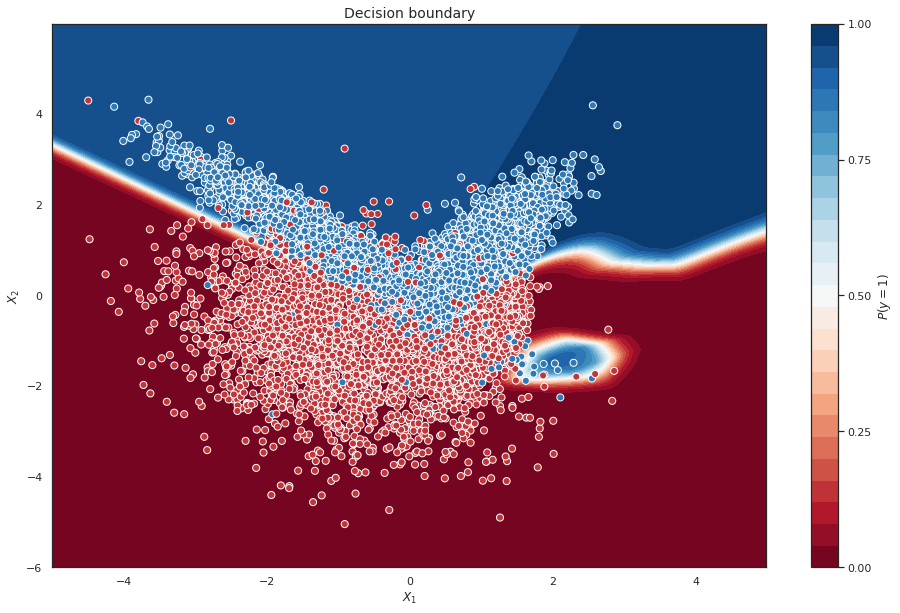

In [ ]:
plot_map(nn_model, X, Y)